In [51]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [52]:
#데이터셋 클래스 정의
class SentimentDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.sentences)
    def __getitem__(self,idx):
        sentences = str(self.sentences[idx])
        label=int(self.labels[idx])
        encoding = self.tokenizer.encode_plus(sentences, add_special_tokens=True,
                                              truncation=True,max_length=self.max_len,return_tensors='pt',
                                              padding='max_length',return_attention_mask=True,return_token_type_ids=False,)
        return {
            'input_ids':encoding['input_ids'].flatten(),
            'attention_mask':encoding['attention_mask'].flatten(),
            'label':torch.tensor(label, dtype=torch.long)
        }

In [53]:
def train_model(model, train_dataloader, optimizer, epochs=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(train_dataloader, desc=f'Epoch {epoch+1}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            
            outputs=model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
        avg_loss = total_loss / len(train_dataloader)
        print(f'Epoch {epoch + 1}/{epochs}, Loss : {avg_loss}')

In [71]:
def evaluate_model(model, dataloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Accuracy: {accuracy*100:.2f}%')

In [55]:
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split

In [56]:
df = pd.read_csv('finance_data.csv')

In [57]:
max_seq_length=df['kor_sentence'].apply(lambda x:len(x)).max()
max_seq_length

195

In [58]:
df['labels'] = df['labels'].replace(['neutral','positive','negative'],[0,1,2])
df[:5]

,labels,sentence,kor_sentence
0,0,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [59]:
del df['sentence']
df

,labels,kor_sentence
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."
...,...,...
4841,2,런던 마켓워치 -- 은행주의 반등이 FTSE 100지수의 약세를 상쇄하지 못하면서 ...
4842,0,린쿠스키아의 맥주 판매량은 416만 리터로 6.5% 감소했으며 카우노 알루스의 맥주...
4843,2,"영업이익은 2007년 68.8 mn에서 35.4 mn으로 떨어졌으며, 선박 판매 이..."
4844,2,페이퍼 부문 순매출은 2008년 2분기 241.1 mn에서 2009년 2분기 221...


<Axes: >

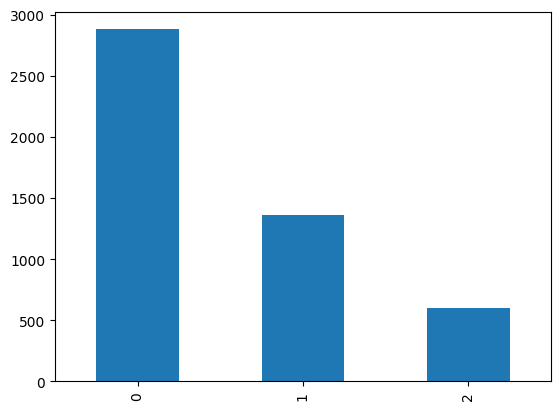

In [60]:
df['labels'].value_counts().plot(kind='bar')

In [61]:
tokenizer=BertTokenizer.from_pretrained('bert-base-multilingual-cased')
sentences=df['kor_sentence'].values
labels = df['labels'].values

In [62]:
sentences

array(['Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로 옮길 계획이 없다고 한다.',
       '테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평방미터 이상의 면적을 단계적으로 개발할 계획이라고 성명은 밝혔다.',
       '국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 해고와는 달리 회사는 사무직 직원 수를 줄였다고 일간 포스티메스가 보도했다.',
       ...,
       '영업이익은 2007년 68.8 mn에서 35.4 mn으로 떨어졌으며, 선박 판매 이익은 12.3 mn이었다.',
       '페이퍼 부문 순매출은 2008년 2분기 241.1 mn에서 2009년 2분기 221.6 mn으로 감소했고, 비반복 항목을 제외한 영업이익은 7.6 mn에서 8.0 mn으로 증가했다.',
       '핀란드에서의 판매는 1월에 10.5% 감소한 반면, 국외에서의 판매는 17% 감소했다.'], dtype=object)

In [63]:
labels

array([0, 0, 2, ..., 2, 2, 2])

In [64]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences,labels,test_size=0.2,random_state=42)

In [65]:
train_df = SentimentDataset(train_sentences, train_labels,tokenizer,max_seq_length)
test_df = SentimentDataset(test_sentences, test_labels,tokenizer,max_seq_length)

In [66]:
train_dataloader = DataLoader(train_df, batch_size = 16, shuffle=True)
test_dataloader = DataLoader(test_df, batch_size = 16, shuffle=False)

In [68]:
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',num_labels=3)
optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/jeonjaehong/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [69]:
train_model(model, train_dataloader, optimizer, epochs=3)

Epoch 1: 100%|████████████████████████████████| 243/243 [12:49<00:00,  3.17s/it]


Epoch 1/3, Loss : 0.6690648558085838


Epoch 2: 100%|████████████████████████████████| 243/243 [13:02<00:00,  3.22s/it]


Epoch 2/3, Loss : 0.44320294196590965


Epoch 3: 100%|████████████████████████████████| 243/243 [12:51<00:00,  3.18s/it]

Epoch 3/3, Loss : 0.3117905499666561


In [72]:
evaluate_model(model, test_dataloader)

Evaluating: 100%|███████████████████████████████| 61/61 [00:51<00:00,  1.19it/s]

Accuracy: 80.62%


In [82]:
def predict_sentiment(model, tokenizer, sentence):
    model.eval()
    
    encoding = tokenizer.encode_plus(
        sentence,
        add_special_tokens = True,
        truncation=True,
        max_length = 128,
        return_tensors='pt',
        padding='max_length',
        return_attention_mask =True,
        return_token_type_ids=False,
    )
    
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).item()
    
    return preds

In [83]:
new_sentences = [
                 '최근 글로벌 경ㅈ데 불안으로 인해 국내 주식 시장에서는 큰 변동이 예상되고 있습니다.',
                 '금리 인상과 관련하여 투자자들은 자산 배분 전략을 재고하고 있으며, 안전자산으로의 이동이 두드러지고 있습니다.',
                 '2022년 상반기 기업 실적 발표가 시작되었는데, 몇몇 대기업들은 예상보다 높은 이익을 기록하고 있습니다.',
                 '국제 무역 전반을 주도하는 중국의 생산 활동이 둔화되고 있어, 이는 세계 경제에 미치는 영향을 우려케 하고 있습니다.',
                 '디지털 화폐 시장에서는 최근 비트코인의 가격이 급등하며 투자자들의 관심을 끌고 있습니다.'
                ]

In [87]:
sentences1 = [
    "글로벌 증시에서는 미국의 금리 인상 기대와 중국의 경제 성장 둔화에 따라 변동성이 확대되고 있습니다.",
"코로나19 팬데믹으로 인한 생산 중단과 물류 난제로 인해 다양한 산업 분야에서 원자재 부족 문제가 대두되고 있습니다.",
"디지털 화폐와 블록체인 기술의 발전으로 금융 시스템이 혁신을 맞이하고 있으며, 이에 따른 규제 논의가 진행 중에 있습니다.",
"2023년 예산안이 발표되면서 정부의 경제 정책 방향과 예상되는 예산 지출에 대한 관심이 커지고 있습니다.",
"글로벌 자동차 산업에서는 전기차 시장의 성장과 함께 자율주행 기술에 대한 투자가 늘어나고 있습니다.",
]

In [89]:
def testing(sentences):
    for i, sentence in enumerate(sentences, 1):
        predicted_label = predict_sentiment(model, tokenizer, sentence)

        print(f"예시 문장 {i} : '{sentence}'")
        if predicted_label == 0:
            print(" -> 감성 : 중립")
        elif predicted_label == 1:
            print(" -> 감성 : 긍정")
        elif predicted_label == 2:
            print(" -> 감성 : 부정")
        print()

In [90]:
testing(new_sentences)

예시 문장 1 : '최근 글로벌 경ㅈ데 불안으로 인해 국내 주식 시장에서는 큰 변동이 예상되고 있습니다.'
 -> 감성 : 부정

예시 문장 2 : '금리 인상과 관련하여 투자자들은 자산 배분 전략을 재고하고 있으며, 안전자산으로의 이동이 두드러지고 있습니다.'
 -> 감성 : 중립

예시 문장 3 : '2022년 상반기 기업 실적 발표가 시작되었는데, 몇몇 대기업들은 예상보다 높은 이익을 기록하고 있습니다.'
 -> 감성 : 부정

예시 문장 4 : '국제 무역 전반을 주도하는 중국의 생산 활동이 둔화되고 있어, 이는 세계 경제에 미치는 영향을 우려케 하고 있습니다.'
 -> 감성 : 부정

예시 문장 5 : '디지털 화폐 시장에서는 최근 비트코인의 가격이 급등하며 투자자들의 관심을 끌고 있습니다.'
 -> 감성 : 부정



In [91]:
testing(sentences1)

예시 문장 1 : '글로벌 증시에서는 미국의 금리 인상 기대와 중국의 경제 성장 둔화에 따라 변동성이 확대되고 있습니다.'
 -> 감성 : 긍정

예시 문장 2 : '코로나19 팬데믹으로 인한 생산 중단과 물류 난제로 인해 다양한 산업 분야에서 원자재 부족 문제가 대두되고 있습니다.'
 -> 감성 : 부정

예시 문장 3 : '디지털 화폐와 블록체인 기술의 발전으로 금융 시스템이 혁신을 맞이하고 있으며, 이에 따른 규제 논의가 진행 중에 있습니다.'
 -> 감성 : 중립

예시 문장 4 : '2023년 예산안이 발표되면서 정부의 경제 정책 방향과 예상되는 예산 지출에 대한 관심이 커지고 있습니다.'
 -> 감성 : 긍정

예시 문장 5 : '글로벌 자동차 산업에서는 전기차 시장의 성장과 함께 자율주행 기술에 대한 투자가 늘어나고 있습니다.'
 -> 감성 : 긍정



In [92]:
torch.save(model.state_dict(),'sentiment_model.pth')